## 2D layered in homogenous velocity

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.lsm       import LSM
from pylops.waveeqprocessing.kirchhoff import Kirchhoff

from pylops.optimization.basic import lsqr as pylops_lsqr

# Params
dynamic = False
cp = np
dtype = np.float32

if cp == np:
    cp_asnumpy = cp.asarray
else:
    cp_asnumpy = cp.asnumpy

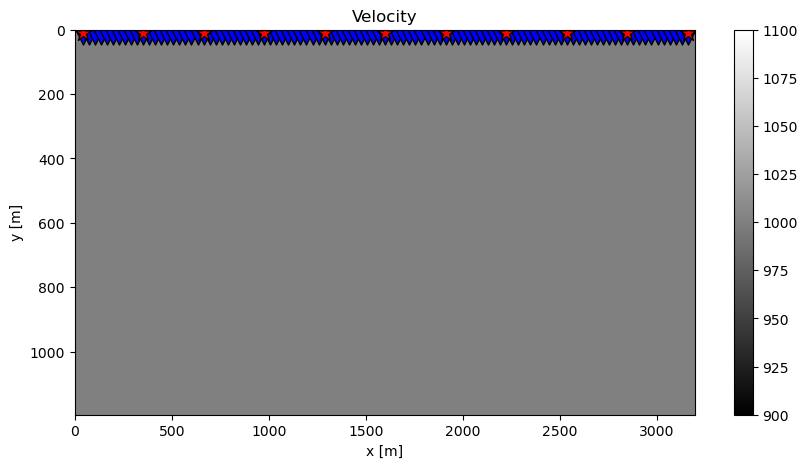

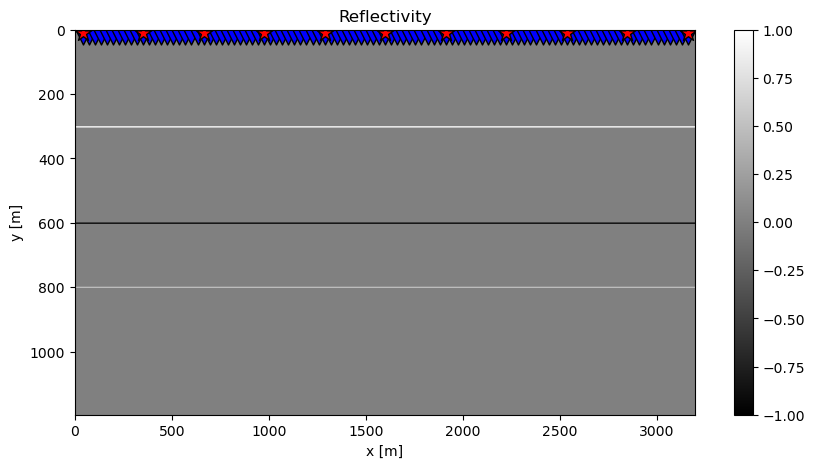

In [2]:
# Velocity Model
nx, nz = 800, 300 # 300, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz), dtype=dtype)
refl[:, nz//4] = 1
refl[:, nz//2] = -1
refl[:, 2*nz//3] = 0.5

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 11
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

# Wavelet
nt = 1001
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

## Numba: multi core

In [3]:
lsmnp = LSM(z, x, t, sources, recs, v0, wav.astype(dtype), wavc, mode='analytic',
            engine='numba', dynamic=dynamic, dtype=dtype)
lsmnp.Demop.trav_srcs = lsmnp.Demop.trav_srcs.astype(dtype)
lsmnp.Demop.trav_recs = lsmnp.Demop.trav_recs.astype(dtype)
# dottest(lsmnp.Demop, atol=1e-3, verb=True);

Forward / Adjoint

In [4]:
dnp = lsmnp.Demop.matvec(refl.ravel())
dnp = dnp.reshape(ns, nr, nt)

madjnp = lsmnp.Demop.rmatvec(dnp.ravel())
madjnp = madjnp.reshape(nx, nz)

dnp.dtype, madjnp.dtype

(dtype('float32'), dtype('float32'))

Inversion

In [5]:
minvnp = lsmnp.solve(dnp.ravel(), solver=pylops_lsqr, **dict(x0=np.zeros_like(refl, dtype=dtype).ravel(), niter=10, show=True))
minvnp = minvnp.reshape(nx, nz)

dinvnp = lsmnp.Demop * minvnp.ravel()
dinvnp = dinvnp.reshape(ns, nr, nt)

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 1112111 rows and 240000 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       10
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  7.718e+03  7.718e+03   1.0e+00  1.2e-01
     1  1.4443e-04  5.694e+03  5.694e+03   7.4e-01  6.8e-01  1.4e+03  1.0e+00
     2  1.1058e-03  4.965e+03  4.965e+03   6.4e-01  5.9e-01  2.4e+03  2.4e+00
     3  2.1258e-03  4.615e+03  4.615e+03   6.0e-01  5.6e-01  3.6e+03  4.3e+00
     4  4.3502e-03  4.091e+03  4.091e+03   5.3e-01  3.2e-01  4.6e+03  6.9e+00
     5  9.2887e-03  3.230e+03  3.230e+03   4.2e-01  1.8e-01  4.8e+03  1.0e+01
     6  2.8304e-03  2.660e+03  2.660e+03   3.4e-01  1.5e-01  4.9e+03  1.4e+01
     7  1.

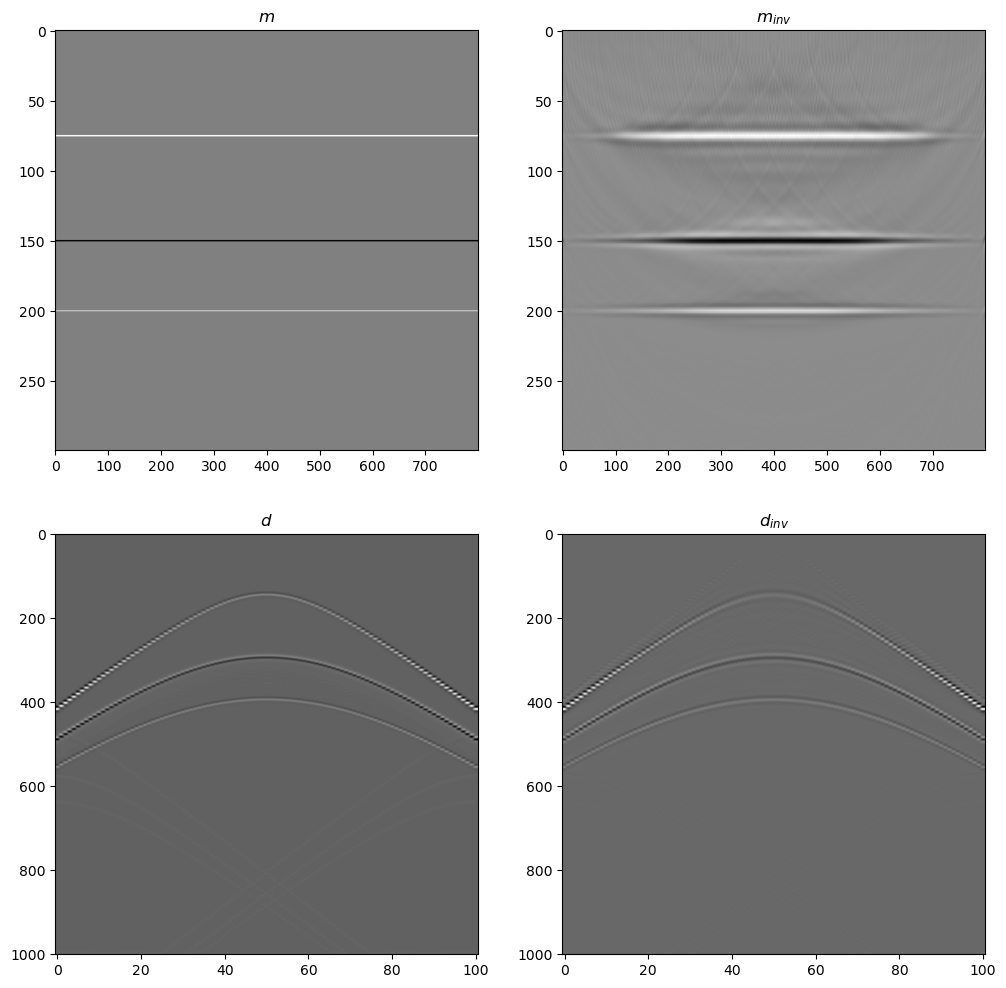

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Adjusting to a 2x2 grid

# First subplot: refl
axs[0, 0].imshow(refl.T, cmap='gray')
axs[0, 0].axis('tight')
axs[0, 0].set_title(r'$m$')

# Second subplot: minv
axs[0, 1].imshow(minvnp.T, cmap='gray')  # Moved to the top right position in the new 2x2 grid
axs[0, 1].axis('tight')
axs[0, 1].set_title(r'$m_{inv}$')

# Third subplot: d
axs[1, 0].imshow(dnp[ns//2, :, :].T, cmap='gray')  # Moved to the bottom left position in the new 2x2 grid
axs[1, 0].set_title(r'$d$')
axs[1, 0].axis('tight')

# Fourth subplot: dinv
axs[1, 1].imshow(dinvnp[ns//2, :, :].T, cmap='gray')  # Moved to the bottom right position in the new 2x2 grid
axs[1, 1].set_title(r'$d_{inv}$')
axs[1, 1].axis('tight');

## Numba Cuda

In [7]:
lsmcp = LSM(z, x, t, sources, recs, v0, cp.asarray(wav).astype(dtype), wavc, mode='analytic', engine='cuda', dynamic=dynamic, dtype=dtype)
lsmcp.Demop.trav_srcs = cp.asarray(lsmcp.Demop.trav_srcs)
lsmcp.Demop.trav_recs = cp.asarray(lsmcp.Demop.trav_recs)
#dottest(lsm.Demop, verb=True, backend='cupy');

In [8]:
lsmcp.Demop.cuda_helper.num_threads_per_blocks, lsmcp.Demop.cuda_helper.num_blocks

((32, 32), (1, 4))

Forward / Adjoint

In [9]:
reflcp = cp.asarray(refl)
dcp = lsmcp.Demop * reflcp.ravel()
dcp = dcp.reshape(ns, nr, nt)

madjcp = lsmcp.Demop.H * dcp.ravel()
madjcp = madjcp.reshape(nx, nz)

type(dcp), type(madjcp), dcp.dtype, madjcp.dtype

(numpy.ndarray, numpy.ndarray, dtype('float32'), dtype('float32'))

Inverse

In [10]:
minvcp = lsmcp.solve(dcp.ravel(), solver=pylops_lsqr, **dict(x0=cp.zeros_like(refl, dtype=dtype).ravel(), niter=10, show=True))
minvcp = minvcp.reshape(nx, nz)

dinvcp = lsmcp.Demop * minvcp.ravel()
dinvcp = dinvcp.reshape(ns, nr, nt)

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 1112111 rows and 240000 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       10
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  7.718e+03  7.718e+03   1.0e+00  1.2e-01
     1  1.4450e-04  5.694e+03  5.694e+03   7.4e-01  6.8e-01  1.4e+03  1.0e+00
     2  1.1059e-03  4.965e+03  4.965e+03   6.4e-01  5.9e-01  2.4e+03  2.4e+00
     3  2.1259e-03  4.615e+03  4.615e+03   6.0e-01  5.6e-01  3.6e+03  4.3e+00
     4  4.3504e-03  4.091e+03  4.091e+03   5.3e-01  3.2e-01  4.6e+03  6.9e+00
     5  9.2889e-03  3.230e+03  3.230e+03   4.2e-01  1.8e-01  4.8e+03  1.0e+01
     6  2.8306e-03  2.660e+03  2.660e+03   3.4e-01  1.5e-01  4.9e+03  1.4e+01
     7  1.

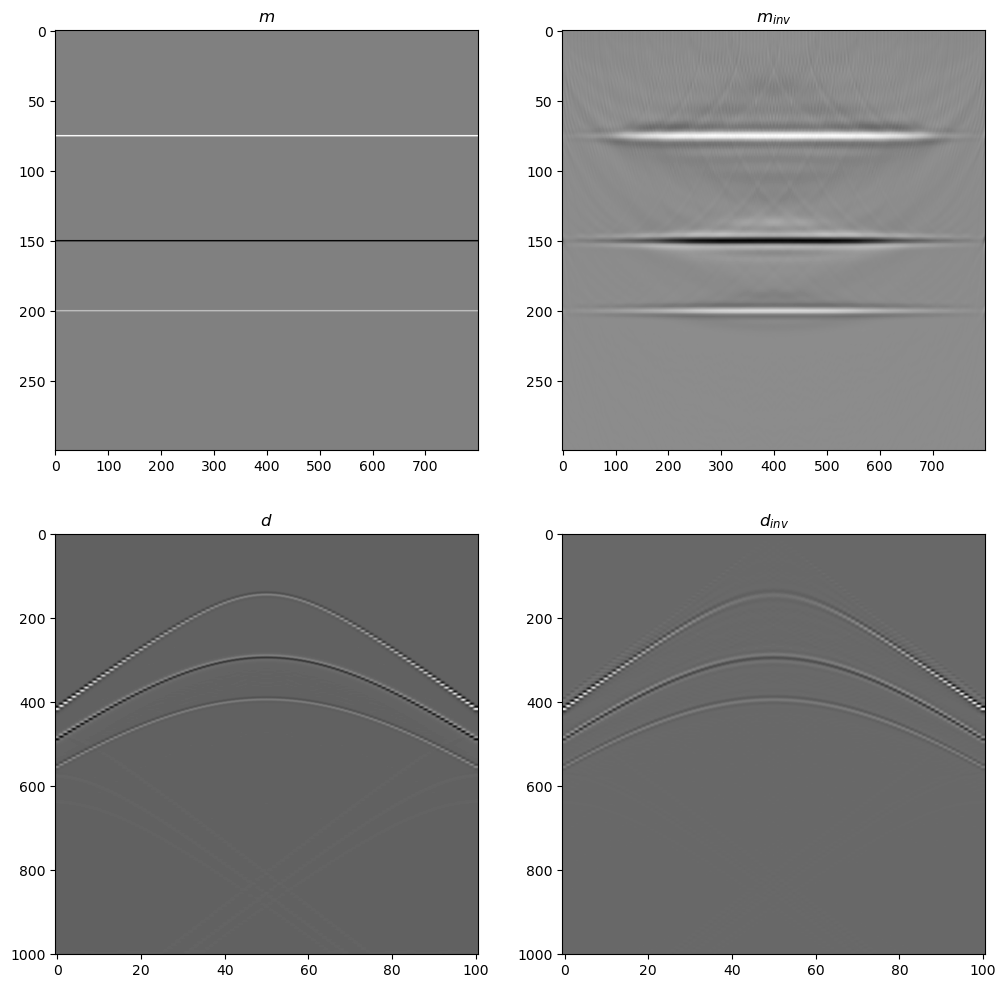

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Adjusting to a 2x2 grid

# First subplot: refl
axs[0, 0].imshow(refl.T, cmap='gray')
axs[0, 0].axis('tight')
axs[0, 0].set_title(r'$m$')

# Second subplot: minv
axs[0, 1].imshow(cp_asnumpy(minvcp).T, cmap='gray')  # Moved to the top right position in the new 2x2 grid
axs[0, 1].axis('tight')
axs[0, 1].set_title(r'$m_{inv}$')

# Third subplot: d
axs[1, 0].imshow(cp_asnumpy(dcp)[ns//2, :, :].T, cmap='gray')  # Moved to the bottom left position in the new 2x2 grid
axs[1, 0].set_title(r'$d$')
axs[1, 0].axis('tight')

# Fourth subplot: dinv
axs[1, 1].imshow(cp_asnumpy(dinvcp)[ns//2, :, :].T, cmap='gray')  # Moved to the bottom right position in the new 2x2 grid
axs[1, 1].set_title(r'$d_{inv}$')
axs[1, 1].axis('tight');

## Comparison CPU vs GPU

(True, True)

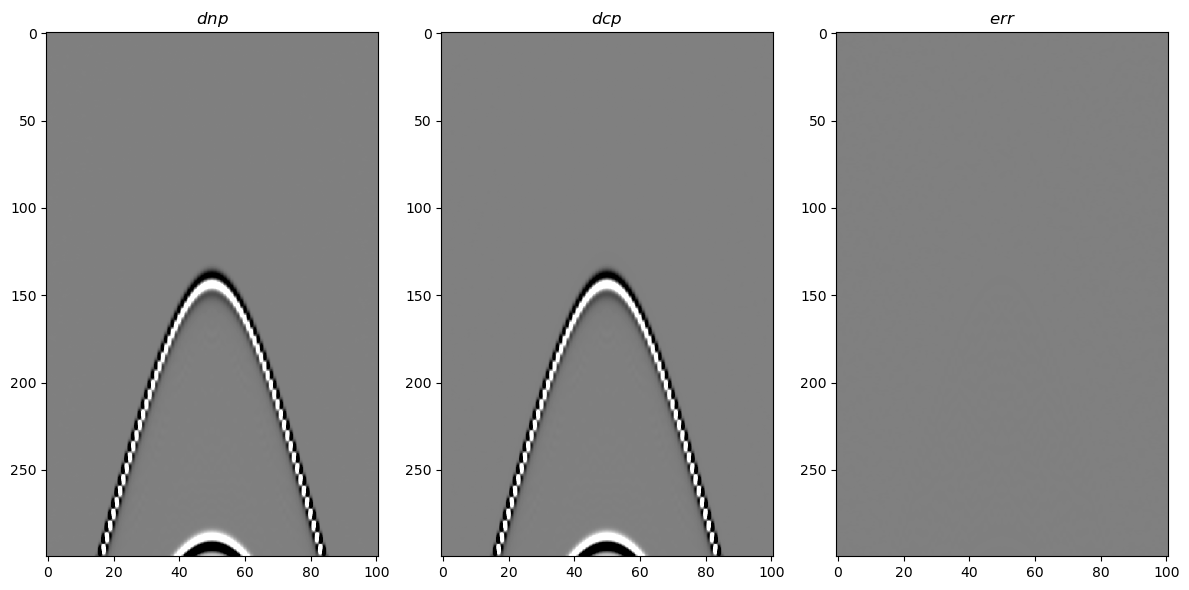

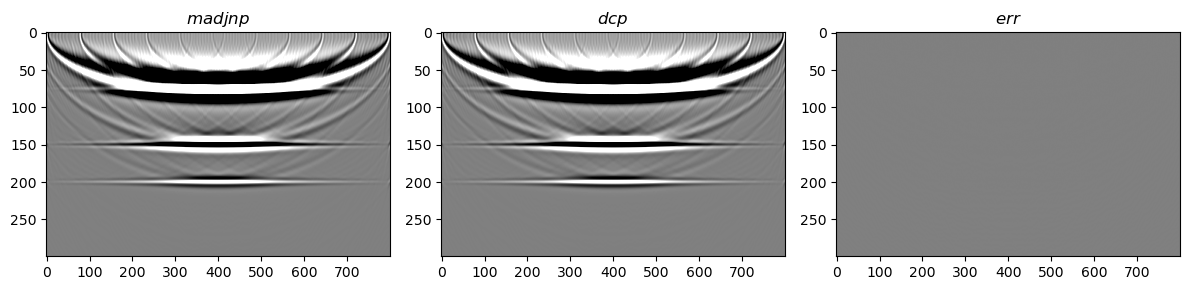

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))  

axs[0].imshow(dnp[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)  
axs[0].set_title(r'$dnp$')
axs[0].axis('tight')

axs[1].imshow(cp_asnumpy(dcp)[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)   
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(dnp[ns//2, :, :300].T - cp_asnumpy(dcp)[ns//2, :, :300].T, 
              cmap='gray', vmin=-1e1, vmax=1e1)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(12, 3))  

axs[0].imshow(madjnp.T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[0].set_title(r'$madjnp$')
axs[0].axis('tight')

axs[1].imshow(cp_asnumpy(madjcp).T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(madjnp.T - cp_asnumpy(madjcp).T, 
              cmap='gray', vmin=-1e4, vmax=1e4)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

np.allclose(dnp, cp_asnumpy(dcp), rtol=1e-2, atol=1e-2), np.allclose(madjnp, cp_asnumpy(madjcp), rtol=1e-1, atol=1e-1)

In [13]:
%timeit -n 5 -r 2 lsmnp.Demop.matvec(refl.ravel())
%timeit -n 5 -r 2 lsmnp.Demop.rmatvec(dnp.ravel())

670 ms ± 10.8 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)
140 ms ± 2.45 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


In [14]:
%timeit -n 5 -r 2 lsmcp.Demop.matvec(reflcp.ravel())
%timeit -n 5 -r 2 lsmcp.Demop.rmatvec(dcp.ravel())

1.38 s ± 3.48 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)
1.37 s ± 11.8 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


In [15]:
Kop = Kirchhoff(z, x, t, sources, recs, v0, 
                wav.astype(dtype), 
                wavc, mode='analytic', 
                engine='cuda', dynamic=dynamic, 
                dtype=dtype)
Top = ToCupy(Kop.dims)
Top1 = ToCupy(Kop.dimsd)
Kop = Top1.H @ Kop @ Top

In [16]:
dcp1 = Kop * refl.ravel()
dcp1 = dcp1.reshape(ns, nr, nt)

madjcp1 = Kop.H * dcp1.ravel()
madjcp1 = madjcp1.reshape(nx, nz)

type(dcp1), type(madjcp1), dcp1.dtype, madjcp1.dtype

(numpy.ndarray, numpy.ndarray, dtype('float32'), dtype('float32'))

## Numba Cuda with VStack over groups of sources

This is useful when the size of the problem does not allow lifting all of the required variables onto the GPU upfront. Still each operator will lift part of the information for a restricted number of sources on-demand.

In [17]:
nsrop = 3 # number of source for each single operator
Kops = []
for isrc in range(0, ns, 3):
    Kop = Kirchhoff(z, x, t, sources[:, isrc:min(isrc + nsrop, ns)], recs, v0, 
                    wav.astype(dtype), 
                    wavc, mode='analytic', 
                    engine='cuda', dynamic=dynamic, 
                    dtype=dtype)
    Top = ToCupy(Kop.dims, dtype=dtype)
    Top1 = ToCupy(Kop.dimsd, dtype=dtype)
    Kop = Top1.H @ Kop @ Top
    Kops.append(Kop)
Kops = VStack(Kops)

In [18]:
dcp2 = Kops * refl.ravel()
dcp2 = dcp2.reshape(ns, nr, nt)

madjcp2 = Kops.H * dcp2.ravel()
madjcp2 = madjcp2.reshape(nx, nz)

type(dcp2), type(madjcp2), dcp2.dtype, madjcp2.dtype

(numpy.ndarray, numpy.ndarray, dtype('float32'), dtype('float32'))

(True, True)

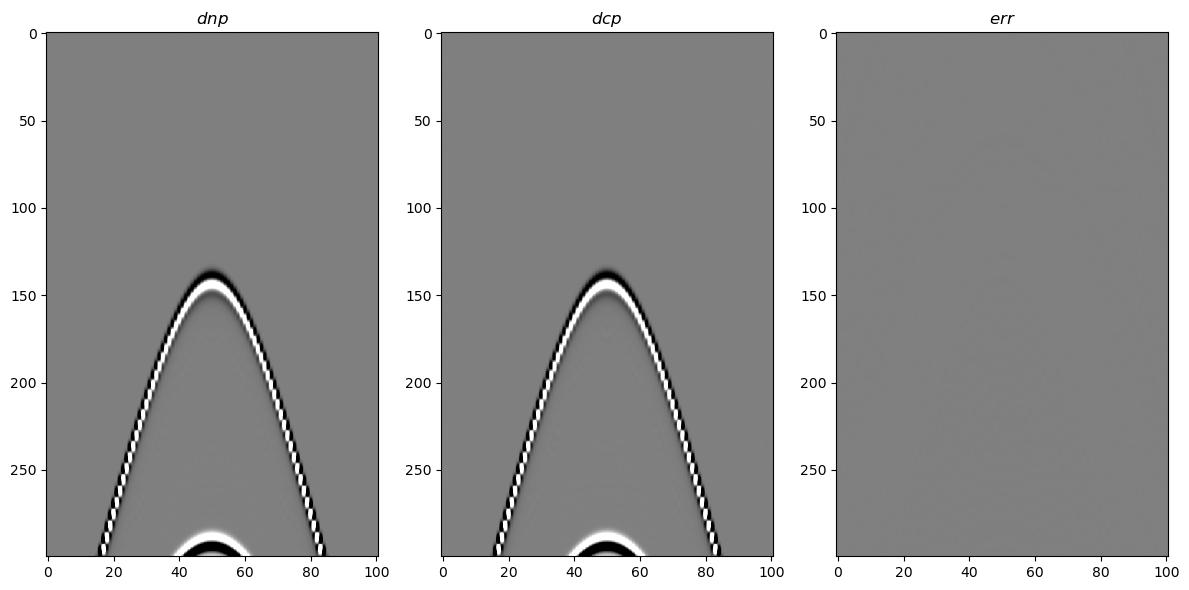

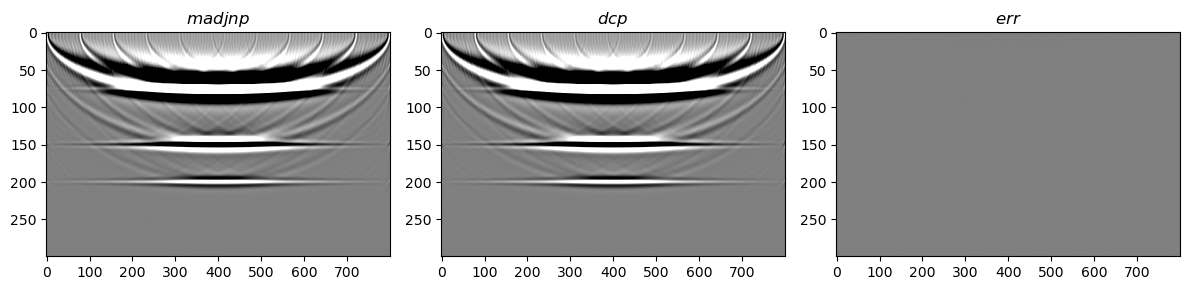

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))  
axs[0].imshow(dnp[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)  
axs[0].set_title(r'$dnp$')
axs[0].axis('tight')

axs[1].imshow(dcp2[ns//2, :, :300].T, cmap='gray',
              vmin=-1e1, vmax=1e1)   
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(dnp[ns//2, :, :300].T - dcp2[ns//2, :, :300].T, 
              cmap='gray', vmin=-1e1, vmax=1e1)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(12, 3))  
axs[0].imshow(madjnp.T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[0].set_title(r'$madjnp$')
axs[0].axis('tight')

axs[1].imshow(madjcp2.T, cmap='gray',
              vmin=-1e4, vmax=1e4)  
axs[1].set_title(r'$dcp$')
axs[1].axis('tight')

axs[2].imshow(madjnp.T - madjcp2.T, 
              cmap='gray', vmin=-1e4, vmax=1e4)  
axs[2].set_title(r'$err$')
axs[2].axis('tight')
plt.tight_layout()

np.allclose(dnp, dcp2, rtol=1e-2, atol=1e-2), np.allclose(madjnp, madjcp2, rtol=1e-1, atol=1e-1)